In [1]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA

In [2]:
def resize_image(image, target_size):

    original_height, original_width, _ = image.shape
    target_width, target_height = target_size
    resized_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    
    for i in range(target_height):
        for j in range(target_width):
            original_x = int(j * original_width / target_width)
            original_y = int(i * original_height / target_height)
            resized_image[i, j] = image[original_y, original_x]
    
    return resized_image

In [3]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        for filename in tqdm(os.listdir(folder+label)):
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (300, 300))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [4]:
data, filenames,label, path, distribusi = insertGambar("selected_flower/") 
print("Data: ", len(data))
print("Label: ", len(label))
print("Filenames: ", len(filenames))
print("Data Distribution: ", distribusi)

Dendellion


100%|██████████| 100/100 [00:09<00:00, 10.95it/s]


Rose


100%|██████████| 100/100 [00:09<00:00, 10.83it/s]


Sunflower


100%|██████████| 100/100 [00:08<00:00, 11.30it/s]

Data:  300
Label:  3
Filenames:  300
Data Distribution:  {'Dendellion': 100, 'Rose': 100, 'Sunflower': 100}


In [5]:
def displayImg(row, column, data):
    fig = plt.figure(figsize=(20, 20))
    for i in range(1, row*column +1):
        fig.add_subplot(row, column, i)
        plt.imshow(data[i-1], cmap='gray')
    plt.show()

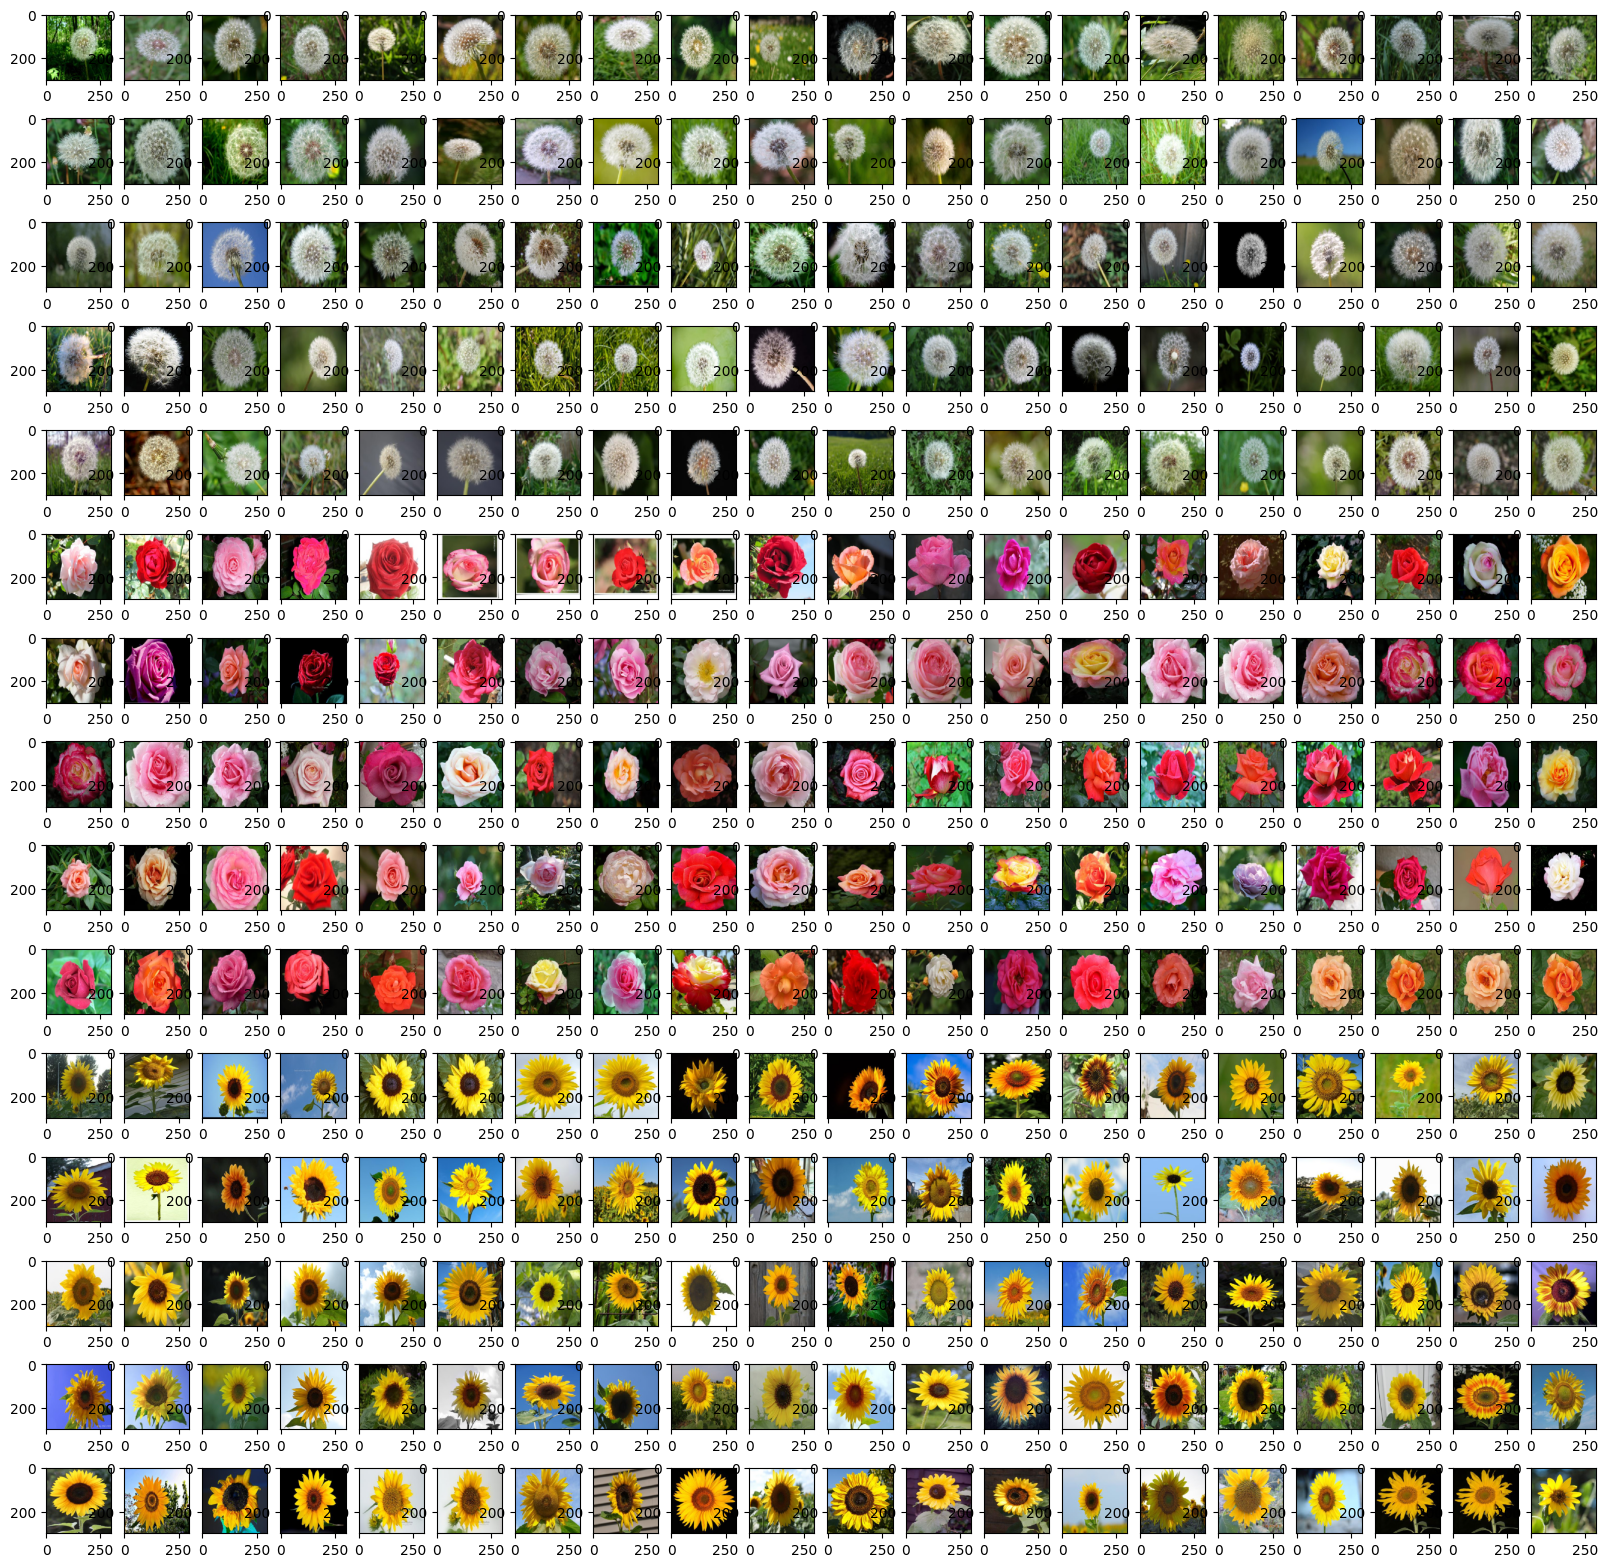

In [6]:
displayImg(15, 20, data)

In [7]:
def grayScaling(img):
    gaussKernel = np.ones((3,3))/9
    r = img[:,:,2]
    g = img[:,:,1]
    b = img[:,:,0]
    filteredR = cv.filter2D(r,-1,gaussKernel)
    filteredG = cv.filter2D(g,-1,gaussKernel)
    filteredB = cv.filter2D(b,-1,gaussKernel)
    return np.round(filteredR/3 + filteredG/3 + filteredB/3).astype(np.uint8)

def grayScalingData(data):
    gray_data = []
    for i in tqdm(range(len(data))):
        gray_data.append(grayScaling(data[i]))
    return gray_data

100%|██████████| 300/300 [00:00<00:00, 399.23it/s]


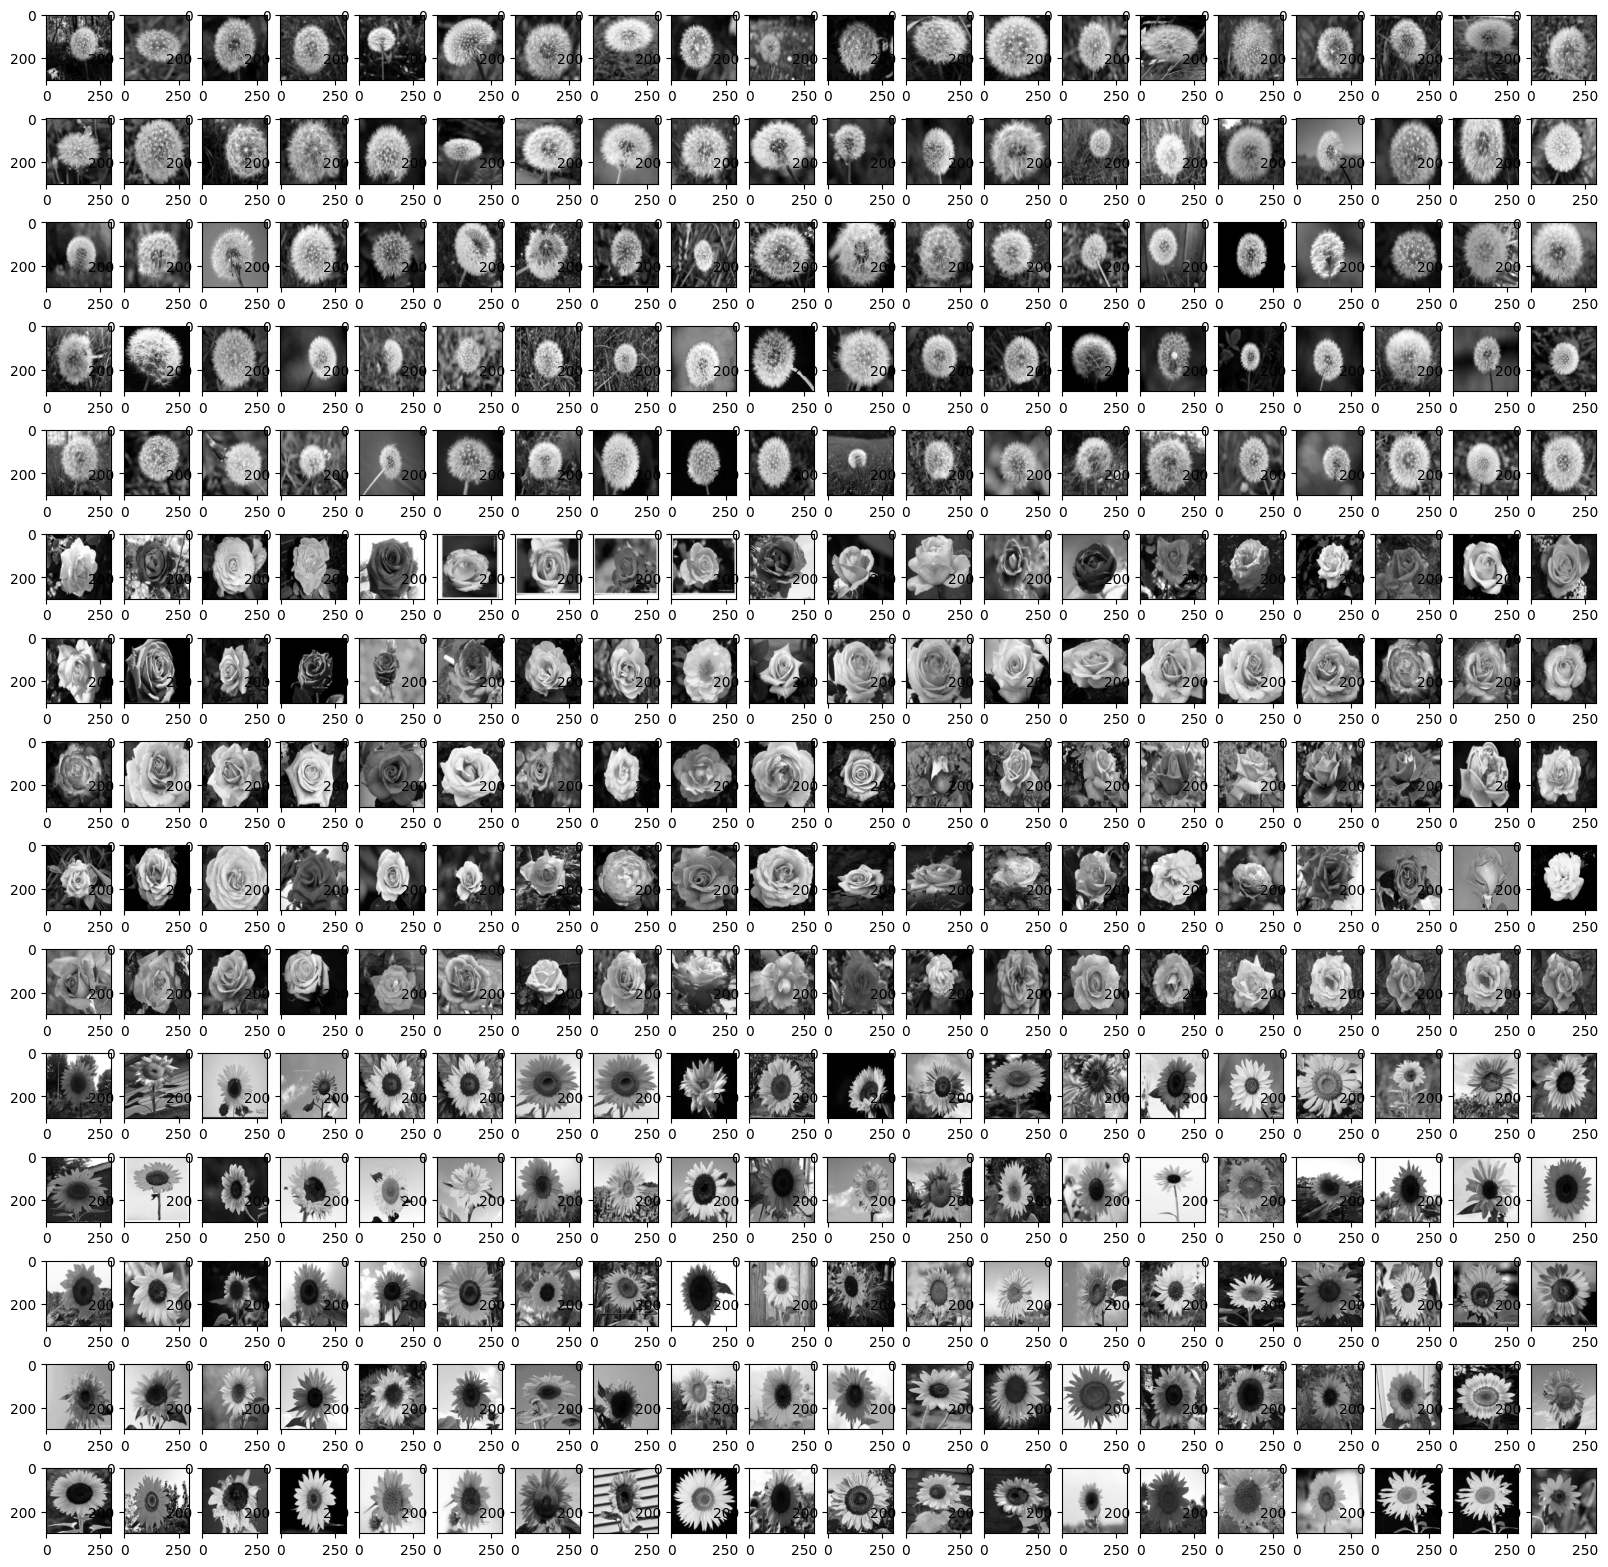

In [8]:
grayData = grayScalingData(data)
displayImg(15, 20, grayData)

In [9]:
def matriksTransformasi(matriks):
    hasil = np.zeros(matriks.shape)
    for i in range(matriks.shape[0]):
        for j in range(matriks.shape[1]):
            hasil[i][j] = matriks[j][i]
    return hasil
def sum(matriks):
    hasil = 0
    for i in range(len(matriks)):
        for j in range(len(matriks[0])):
            hasil += matriks[i][j]
    return hasil

def derajat(img, derajat):
    max = np.max(img)
    temp=np.zeros([max+1,max+1])
    if derajat == 0:
        for i in range (len(img)):
            for j in range (len(img[0])-1):
                temp[img[i,j],img[i,j+1]] += 1
    elif derajat == 45:
        for i in range (len (img)-1):
            for j in range (len (img[0])-1):
                temp[img[i+1,j],img[i,j+1]] += 1
    elif derajat == 90:
        for i in range (len (img)-1):
            for j in range (len (img[0])):
                temp[img[i+1,j],img[i,j]] += 1
    elif derajat == 135:
        for i in range (len (img)-1):
            for j in range (len (img[0])-1):
                temp[img[i,j],img[i+1,j+1]] += 1
    hasil = temp+matriksTransformasi(temp)
    total = sum(hasil)
    for i in range (len (hasil)):
        for j in range (len (hasil)):
            hasil[i,j]/=total
    return hasil

def ekstraksi(image):
    hasil = []
    for img in tqdm(image):
        data = []
        data.append(derajat(img,0))
        data.append(derajat(img,45))
        data.append(derajat(img,90))
        data.append(derajat(img,135))
        hasil.append(data)    
    return hasil

In [10]:
ekstraksiData = ekstraksi(grayData)

100%|██████████| 300/300 [04:02<00:00,  1.24it/s]


In [11]:
def contrast (data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=data[i,j]*pow(i-j,2)
    return hasil
def dissimilarity(data):  
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=data[i,j]*abs(i-j)
    return hasil
def homogeneity(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=(data[i,j]/(1+pow(i-j,2)))
    return hasil
def energy(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i][j] ** 2
    return hasil

def correlation(data):
    mean_x = 0
    mean_y = 0
    std_x = 0
    std_y = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            mean_x += i * data[i][j]
            mean_y += j * data[i][j]
    for i in range(len(data)):
        for j in range(len(data[0])):
            std_x += (i - mean_x) ** 2 * data[i][j]
            std_y += (j - mean_y) ** 2 * data[i][j]
    std_x = math.sqrt(std_x)
    std_y = math.sqrt(std_y)
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += (i - mean_x) * (j - mean_y) * data[i][j]
    hasil /= std_x * std_y
    return hasil

def entropy(data):
    entropy = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            if data[i][j] > 0.0:
                entropy += -(data[i][j] * math.log(data[i][j]))
    return entropy
def asm(data):
    asm = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            asm += data[i][j] ** 2
    return asm

In [12]:
def ekstraksiFitur(data, path):
    hasil = []
    batas_gambar = len(data)
    for i in tqdm(range(batas_gambar)):
        extracted_data = [path[i]]
        for j in range(len(data[i])):
            contrast_val = contrast(data[i][j])
            extracted_data.append(contrast_val)
        for j in range(len(data[i])):
            dissimilarity_val = dissimilarity(data[i][j])
            extracted_data.append(dissimilarity_val)
        for j in range(len(data[i])):
            homogeneity_val = homogeneity(data[i][j])
            extracted_data.append(homogeneity_val)
        for j in range(len(data[i])):
            energy_val = energy(data[i][j])
            extracted_data.append(energy_val)
        for j in range(len(data[i])):
            correlation_val = correlation(data[i][j])
            extracted_data.append(correlation_val)
        for j in range(len(data[i])):
            asm_val = asm(data[i][j])
            extracted_data.append(asm_val)
            entropy_val = entropy(data[i][j])
            extracted_data.append(entropy_val)
        hasil.append(extracted_data)
    return hasil

In [13]:
angles = ['0', '45', '90', '135']
fiturs = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
headers = ['path']
for fitur in fiturs:
    headers.extend([f'{fitur}_{angle}' for angle in angles])
headers.extend([f'asm_{angle}' for angle in angles])
headers.extend([f'entropy_{angle}' for angle in angles])

In [14]:
hasil = ekstraksiFitur(ekstraksiData, path)
df = pd.DataFrame(hasil, columns=headers)
df

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [09:33<00:00,  1.91s/it]


path  contrast_0  contrast_45  contrast_90  contrast_135  \
0    Dendellion  121.090513   174.187951    60.566589    175.990146   
1    Dendellion   13.148651    25.839129    16.668718     30.465655   
2    Dendellion   34.466020    55.799622    22.154894     52.330119   
3    Dendellion   32.021706    57.282133    24.883333     50.853917   
4    Dendellion   32.728216    64.237179    31.469465     60.478977   
..          ...         ...          ...          ...           ...   
295   Sunflower   38.932586    71.259236    38.248974     73.645519   
296   Sunflower   16.555162    26.120289    10.921405     26.148567   
297   Sunflower   60.171628   120.060749    69.700758    129.215501   
298   Sunflower   60.171628   120.060749    69.700758    129.215501   
299   Sunflower   36.085340    66.983938    34.969588     70.056431   

     dissimilarity_0  dissimilarity_45  dissimilarity_90  dissimilarity_135  \
0           7.124783          8.667006          4.942531           8.667409   
1           2.238417          3.081308          2.449721           3.453966   
2           3.407402          4.378900          2.726198           4.268554   
3           3.892809          5.224953          3.364292           4.888323   
4           3.408885          4.831020          3.217269           4.727788   
..               ...               ...               ...                ...   
295         4.149309          5.643214          4.020992           5.694690   
296         2.068986          2.807799          1.834983           2.852720   
297         3.195596          4.679825          3.436054           4.875796   
298         3.195596          4.679825          3.436054           4.875796   
299         3.110045          4.142314          2.929365           4.494234   

     homogeneity_0  ...  correlation_90  correlation_135     asm_0    asm_45  \
0         0.240311  ...        0.991493         0.975310  0.001006  8.375545   
1         0.441513  ...        0.993831         0.988746  0.001918  7.071038   
2         0.430436  ...        0.996859         0.992591  0.001742  7.587927   
3         0.272653  ...        0.995748         0.991320  0.000757  7.930416   
4         0.367038  ...        0.995336         0.991055  0.001761  7.559839   
..             ...  ...             ...              ...       ...       ...   
295       0.293297  ...        0.983526         0.968253  0.000672  7.922636   
296       0.520102  ...        0.998333         0.996009  0.001957  7.342665   
297       0.588381  ...        0.989497         0.980544  0.022444  5.884966   
298       0.588381  ...        0.989497         0.980544  0.022444  5.884966   
299       0.411606  ...        0.990798         0.981585  0.000836  7.724051   

       asm_90   asm_135  entropy_0  entropy_45  entropy_90  entropy_135  
0    0.000807  8.560060   0.001388    8.032035    0.000828     8.550581  
1    0.001499  7.337330   0.001872    7.121456    0.001268     7.474833  
2    0.001408  7.821004   0.001951    7.409657    0.001291     7.824313  
3    0.000581  8.209105   0.000951    7.767088    0.000627     8.137633  
4    0.001282  7.881261   0.001880    7.483364    0.001333     7.855549  
..        ...       ...        ...         ...         ...          ...  
295  0.000496  8.214279   0.000712    7.885113    0.000501     8.215128  
296  0.001500  7.651353   0.001978    7.272492    0.001534     7.650808  
297  0.018643  6.161754   0.021916    5.915179    0.018220     6.190551  
298  0.018643  6.161754   0.021916    5.915179    0.018220     6.190551  
299  0.000661  7.964063   0.000910    7.645511    0.000601     8.066098  

[300 rows x 29 columns]

In [15]:
df.to_csv('before.csv', index=False)

In [20]:
df = pd.read_csv('before.csv')

x = df.drop('path', axis=1)
y = df['path']

In [21]:
pca = PCA(n_components=28)
x_pca = pca.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [22]:
knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)
print('Accuracy:', accuracy_score(y_test, knn_pred))

svm = SVC(kernel='rbf', C=30, gamma='auto')
svm.fit(x_train, y_train)
svm_pred = svm.predict(x_test)
print('Accuracy:', accuracy_score(y_test, svm_pred))

rfc = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, max_depth=50, min_samples_leaf=1, min_samples_split=2, bootstrap=False, criterion='gini')
rfc.fit(x_train, y_train)
rf_pred = rfc.predict(x_test)
print('Accuracy:', accuracy_score(y_test, rf_pred))

Accuracy: 0.4666666666666667
Accuracy: 0.6333333333333333
Accuracy: 0.75


In [23]:
models = {'KNN': knn_pred, 'SVM': svm_pred, 'Random Forest': rf_pred}
results = {}

for model_name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[model_name] = [accuracy, precision, recall, f1]

results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-Score']).T
print(results_df)

               Accuracy  Precision    Recall  F1-Score
KNN            0.466667   0.468118  0.466667  0.464807
SVM            0.633333   0.631735  0.633333  0.630347
Random Forest  0.750000   0.748068  0.750000  0.748710
